In [1]:
%%capture

!pip3 install pip --upgrade
!pip3 install numpy scipy matplotlib ipywidgets

In [2]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.linalg import eig
from scipy.optimize import fsolve

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [3]:
def default_pars(**kwargs):
    """
    Define the parameters of the dynamical system
    """
    pars = {}

    # Excitatory parameters
    pars['tau_E'] = 1.     # Timescale of the E population [ms]
    pars['a_E'] = 1.2      # Gain of the E population
    pars['theta_E'] = 2.8  # Threshold of the E population

    # Inhibitory parameters
    pars['tau_I'] = 2.0    # Timescale of the I population [ms]
    pars['a_I'] = 1.0      # Gain of the I population
    pars['theta_I'] = 4.0  # Threshold of the I population

    # Connection strength
    pars['wEE'] = 9.   # E to E
    pars['wEI'] = 4.   # I to E
    pars['wIE'] = 13.  # E to I
    pars['wII'] = 11.  # I to I

    # External input
    pars['I_ext_E'] = 0.
    pars['I_ext_I'] = 0.

    # simulation parameters
    pars['T'] = 50.        # Total duration of simulation [ms]
    pars['dt'] = .1        # Simulation time step [ms]
    pars['rE_init'] = 0.2  # Initial value of E
    pars['rI_init'] = 0.2  # Initial value of I

    # External parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    # Vector of discretized time points [ms]
    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

    return pars


def F(x, a, theta):
    """
    Population activation function, F-I curve

    Args:
        x     : the population input
        a     : the gain of the function
        theta : the threshold of the function

    Returns:
        f     : the population activation response f(x) for input x
    """

    f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

    return f


def dF(x, a, theta):
    """
    Derivative of the population activation function.

    Args:
        x     : the population input
        a     : the gain of the function
        theta : the threshold of the function

    Returns:
        dFdx  :  Derivative of the population activation function.
    """

    dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

    return dFdx


def F_inv(x, a, theta):
    """
    Inverse of the population activation function.
    Args:
        x         : the population input
        a         : the gain of the function
        theta     : the threshold of the function

    Returns:
        F_inverse : value of the inverse function
    """

    # Calculate Finverse (ln(x) can be calculated as np.log(x))
    F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta

    return F_inverse


def EIderivs(rE, rI,tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
             tau_I, a_I, theta_I, wIE, wII, I_ext_I,
             **other_pars):
    """
    Time derivatives for E/I variables (dE/dt, dI/dt).
    """

    drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E
    drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

    return drEdt, drIdt

def simulate_wc(tau_E, a_E, theta_E, tau_I, a_I, theta_I,
                wEE, wEI, wIE, wII, I_ext_E, I_ext_I,
                rE_init, rI_init, dt, range_t, **other_pars):
    """
    Simulate the Wilson-Cowan equations

    Args:
        Parameters of the Wilson-Cowan model

    Returns:
        rE, rI (arrays) : Activity of excitatory and inhibitory populations
    """
    # Initialize activity arrays
    Lt = range_t.size
    rE = np.append(rE_init, np.zeros(Lt - 1))
    rI = np.append(rI_init, np.zeros(Lt - 1))
    I_ext_E = I_ext_E * np.ones(Lt)
    I_ext_I = I_ext_I * np.ones(Lt)

    # Simulate the Wilson-Cowan equations
    for k in range(Lt - 1):

        # Calculate the derivative of the E population
        drE = dt / tau_E * (-rE[k] + F(wEE * rE[k] - wEI * rI[k] + I_ext_E[k],
                                   a_E, theta_E))

        # Calculate the derivative of the I population
        drI = dt / tau_I * (-rI[k] + F(wIE * rE[k] - wII * rI[k] + I_ext_I[k],
                                   a_I, theta_I))

        # Update using Euler's method
        rE[k + 1] = rE[k] + drE
        rI[k + 1] = rI[k] + drI

    return rE, rI

## Plotting Functions

In [4]:
def plot_FI_inverse(x, a, theta):
    """
    Plot the inverse of the activation function
    """
    f, ax = plt.subplots()
    ax.plot(x, F_inv(x, a=a, theta=theta))
    ax.set(xlabel="$x$", ylabel="$F^{-1}(x)$")


def plot_FI_EI(x, FI_exc, FI_inh):
    """
    Plot the activation fuction for the E and I populations
    """
    plt.figure()
    plt.plot(x, FI_exc, 'b', label='E population')
    plt.plot(x, FI_inh, 'r', label='I population')
    plt.legend(loc='lower right')
    plt.xlabel('x (a.u.)')
    plt.ylabel('F(x)')
    plt.show()


def my_test_plot(t, rE1, rI1, rE2, rI2):
    """
    Plot activities of E and I population for two different initial conditions
    """

    plt.figure()
    ax1 = plt.subplot(211)
    ax1.plot(pars['range_t'], rE1, 'b', label='E population')
    ax1.plot(pars['range_t'], rI1, 'r', label='I population')
    ax1.set_ylabel('Activity')
    ax1.legend(loc='best')

    ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
    ax2.plot(pars['range_t'], rE2, 'b', label='E population')
    ax2.plot(pars['range_t'], rI2, 'r', label='I population')
    ax2.set_xlabel('t (ms)')
    ax2.set_ylabel('Activity')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()


## Simulate the activity

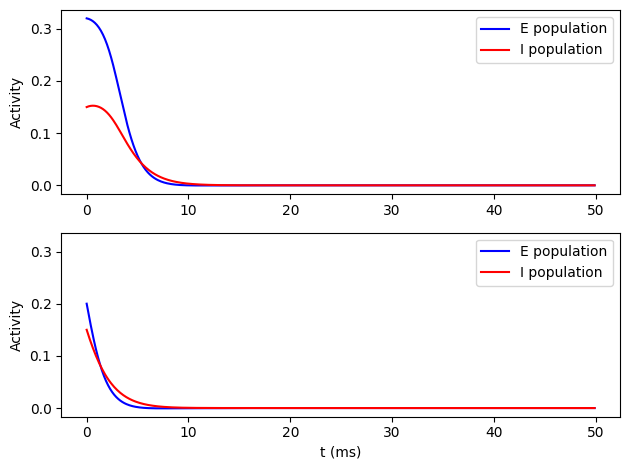

In [5]:
pars = default_pars()


# Simulate first trajectory
rE1, rI1 = simulate_wc(**default_pars(rE_init=.32, rI_init=.15))

# Simulate second trajectory
rE2, rI2 = simulate_wc(**default_pars(rE_init=.2, rI_init=.15))

"""
# Simulate first trajectory
rE1, rI1 = simulate_wc(**default_pars(rE_init=.32, rI_init=.15),wEE=6.4,wEI=4.8,wIE=6.0,WII=1.2)

# Simulate second trajectory
rE2, rI2 = simulate_wc(**default_pars(rE_init=.2, rI_init=.15))
"""

my_test_plot(pars['range_t'], rE1, rI1, rE2, rI2)

## Task 1: Find the steady states

#### Plot the nullclines

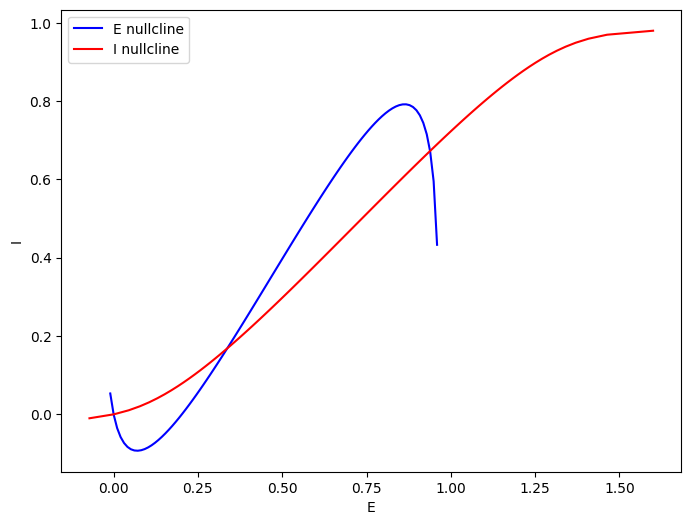

In [6]:
# The parameters values, especially the connection strengths, are already set in the default parameters.
def nullcline_E(rE, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):
  """
  Solve for rI along the rE from drE/dt = 0.

  Args:
    rE    : response of excitatory population
    a_E, theta_E, wEE, wEI, I_ext_E : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rI = 1 / wEI * (wEE * rE - F_inv(rE, a_E, theta_E) + I_ext_E)

  return rI


def nullcline_I(rI, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """
  Solve for E along the rI from dI/dt = 0.

  Args:
    rI    : response of inhibitory population
    a_I, theta_I, wIE, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE    : values of the excitatory population along the nullcline on the rI
  """
  # calculate rE for I nullclines on rI
  rE = 1 / wIE * (wII * rI + F_inv(rI, a_I, theta_I) - I_ext_I)

  return rE

Exc_null_rE = np.linspace(-0.01, 1, 100)
Exc_null_rI = nullcline_E(Exc_null_rE, **pars)
Inh_null_rI = np.linspace(-0.01, 1, 100)
Inh_null_rE = nullcline_I(Inh_null_rI, **pars)

plt.figure(figsize=(8, 6))
plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
plt.xlabel('E')
plt.ylabel('I')
plt.legend(loc='best')
plt.show()

#### Find and plot the critical points

Intersection point (rE, rI): [0.33685241 0.16841968]
Intersection point 2 (rE, rI): [0.e+000 5.e-324]
Intersection point 3 (rE, rI): [0.93843047 0.67248104]


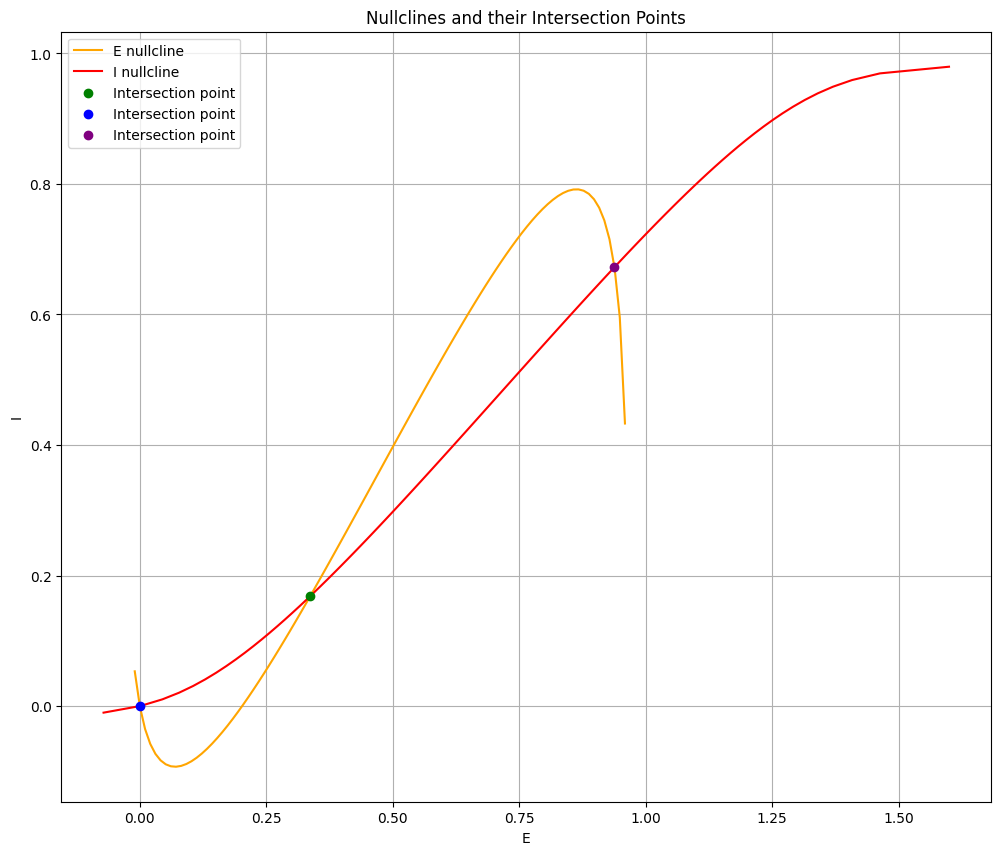

In [7]:
def nullcline_difference(r, *args):
    rE, rI = r
    # Unpack parameters
    a_E, theta_E, wEE, wEI, I_ext_E, a_I, theta_I, wIE, wII, I_ext_I = args
    # Calculate difference from each nullcline
    diff_E = nullcline_E(rE, a_E, theta_E, wEE, wEI, I_ext_E) - rI
    diff_I = nullcline_I(rI, a_I, theta_I, wIE, wII, I_ext_I) - rE
    return [diff_E, diff_I]

# Parameters for the root finding, adjust as necessary - Starting point for the search
initial_guess = [0.3, 0.3]
initial_guess2 = [0.01, 0.01]
initial_guess3 = [0.9, 0.8]

args = (pars['a_E'], pars['theta_E'], pars['wEE'], pars['wEI'], pars['I_ext_E'],
        pars['a_I'], pars['theta_I'], pars['wIE'], pars['wII'], pars['I_ext_I'])

# Find the intersection point using fsolve
intersection_point = fsolve(nullcline_difference, initial_guess, args=args)
intersection_point2 = fsolve(nullcline_difference, initial_guess2, args=args)
intersection_point3 = fsolve(nullcline_difference, initial_guess3, args=args)

print(f"Intersection point (rE, rI): {intersection_point}")
print(f"Intersection point 2 (rE, rI): {intersection_point2}")
print(f"Intersection point 3 (rE, rI): {intersection_point3}")

plt.figure(figsize=(12, 10))
plt.plot(Exc_null_rE, Exc_null_rI, 'orange', label='E nullcline')
plt.plot(Inh_null_rE, Inh_null_rI, 'red', label='I nullcline')
plt.scatter(intersection_point[0], intersection_point[1], color='green', zorder=5, label='Intersection point')
plt.scatter(intersection_point2[0], intersection_point2[1], color='blue', zorder=5, label='Intersection point')
plt.scatter(intersection_point3[0], intersection_point3[1], color='purple', zorder=5, label='Intersection point')
plt.xlabel('E')
plt.ylabel('I')
plt.title('Nullclines and their Intersection Points')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Task 2: Classification of Critical Points

In [8]:
def get_eig_Jacobian(fp,tau_E, a_E, theta_E, wEE, wEI, I_ext_E, tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
  # Initialization
  rE, rI = fp
  J = np.zeros((2, 2))
  # Compute the four elements of the Jacobian matrix
  J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

  J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

  J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

  J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

  # Compute and return the eigenvalues
  evals = np.linalg.eig(J)[0]
  return evals

eig_1 = get_eig_Jacobian(intersection_point, **pars)
eig_2 = get_eig_Jacobian(intersection_point2, **pars)
eig_3 = get_eig_Jacobian(intersection_point3, **pars)

aList = [intersection_point, intersection_point2, intersection_point3]
aList2 = [eig_1, eig_2, eig_3]

for inter, eig in zip(aList, aList2):
    if np.all(np.real(eig) < 0):
        print(f"Critical Point {inter} = {eig}: Stable (Attractive)")
    elif np.any(np.real(eig) > 0):
        print(f"Critical Point {inter} = {eig}: Unstable (Repulsive)")
    else:
        pass


Critical Point [0.33685241 0.16841968] = [ 1.05720798 -0.87266898]: Unstable (Repulsive)
Critical Point [0.e+000 5.e-324] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)
Critical Point [0.93843047 0.67248104] = [-0.95956219 -1.42197413]: Stable (Attractive)


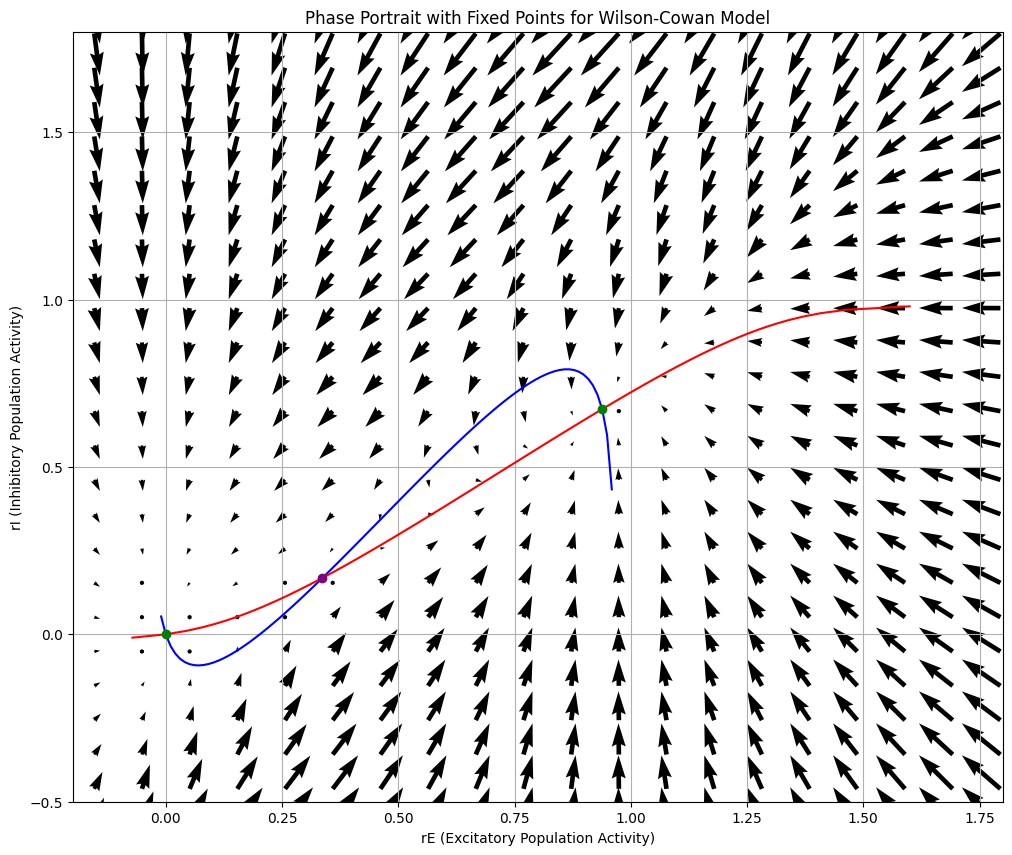

In [9]:
# Define the system of derivatives for the Wilson-Cowan model
def system_derivatives(rE, rI, tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
                       tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
    drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E
    drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I
    return np.array([drEdt, drIdt])

plt.figure(figsize=(12, 10))
# Generate a grid
x, y = np.meshgrid(np.linspace(-2, 2, 40), np.linspace(-2, 2, 40))

# Compute derivatives for each point on the grid
u, v = np.zeros(x.shape), np.zeros(y.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        derivatives = system_derivatives(x[i, j], y[i, j], **pars)
        u[i, j], v[i, j] = derivatives

# Plot the vector field
plt.quiver(x, y, u, v, color='black', scale=20, width=0.005)

# Comprehensive Plot (blue: stable points, green: unstable points)
plt.xlim([-0.2, 1.8])
plt.ylim([-0.5, 1.8])
plt.plot(Exc_null_rE, Exc_null_rI, 'blue', label='E nullcline')
plt.plot(Inh_null_rE, Inh_null_rI, 'red', label='I nullcline')
plt.scatter(intersection_point[0], intersection_point[1], color='purple', zorder=5, label='Intersection point', marker='o')
plt.scatter(intersection_point2[0], intersection_point2[1], color='green', zorder=5, label='Intersection point', marker='o')
plt.scatter(intersection_point3[0], intersection_point3[1], color='green', zorder=5, label='Intersection point', marker='o')
plt.xlabel('rE (Excitatory Population Activity)')
plt.ylabel('rI (Inhibitory Population Activity)')
plt.title('Phase Portrait with Fixed Points for Wilson-Cowan Model')
plt.grid(True)
plt.show()


##### The phase portrait remarks that:
##### Critical Point [0.33685241 0.16841968] = [ 1.05720798 -0.87266898]: Unstable (Repulsive)
##### Critical Point [0.e+000 5.e-324] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)
##### Critical Point [0.93843047 0.67248104] = [-0.95956219 -1.42197413]: Stable (Attractive)

## Task 3: Change the nonlinearities

### Higher Gain: test 1

Increasing the gain while keeping the threshold constant allows you to observe the effects of heightened sensitivity to inputs near the threshold. A high gain means that the transition from low to high firing rates occurs over a smaller range of input values, simulating a more binary-like response. This setting can be useful for studying conditions under which neural populations might act in a more switch-like manner.

Critical Point [0.32904467 0.12023428] = [ 1.04776532 -1.00332061]: Unstable (Repulsive)


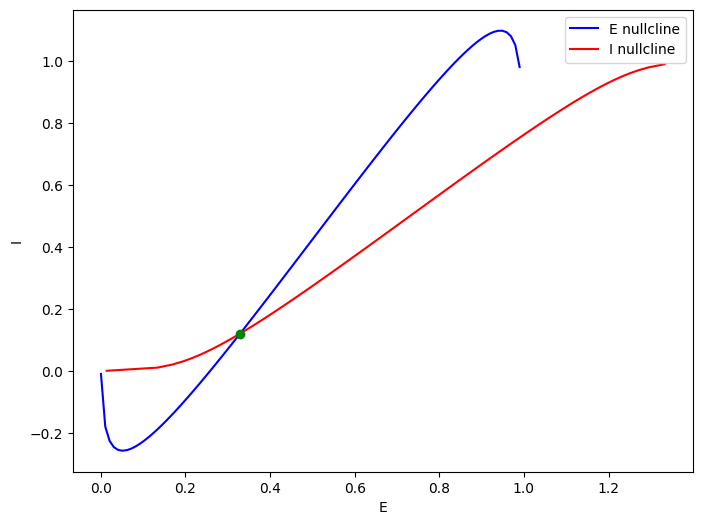

Intersection point (rE, rI): [0.32904467 0.12023428]


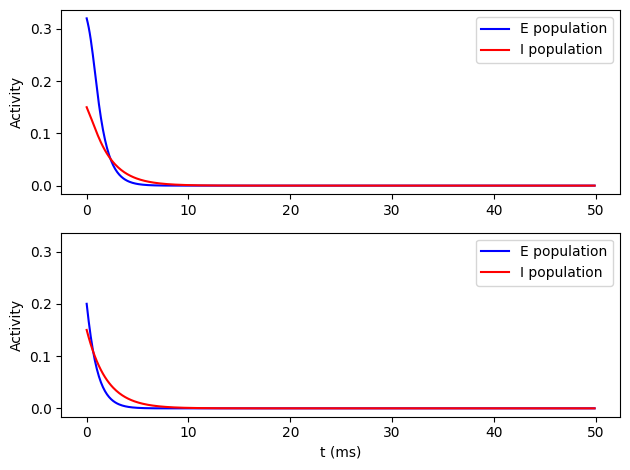

In [10]:
#parameters to change: a_E, a_I.

#baseline gain values:
#pars['a_E'] = 1.2
#pars['a_I'] = 1.0

def higher_gain_test(a, b, pars):
    # Copy of the pars dictionary to avoid modifying the original
    local_pars = pars.copy()
    
    # Update the copy with the new gain values
    local_pars['a_E'] = a
    local_pars['a_I'] = b

    # Generate nullclines using the updated local parameters
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])

    # Adjust the initial_guess and args as needed
    initial_guess = [0.3, 0]
    args = (local_pars['a_E'], local_pars['theta_E'], local_pars['wEE'], local_pars['wEI'], local_pars['I_ext_E'],
            local_pars['a_I'], local_pars['theta_I'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_I'])

    # Find the intersection point using fsolve
    intersection_point = fsolve(nullcline_difference, initial_guess, args=args)

    def get_eig_Jacobian(fp,tau_E, a_E, theta_E, wEE, wEI, I_ext_E, tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
        """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
        # Initialization
        rE, rI = fp
        J = np.zeros((2, 2))
        # Compute the four elements of the Jacobian matrix
        J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        # Compute and return the eigenvalues
        evals = np.linalg.eig(J)[0]
        return evals

    eig_1 = get_eig_Jacobian(intersection_point, **pars)

    aList = [intersection_point]
    aList2 = [eig_1]

    for inter, eig in zip(aList, aList2):
        if np.all(np.real(eig) < 0):
            print(f"Critical Point {inter} = {eig}: Stable (Attractive)")
        elif np.any(np.real(eig) > 0):
            print(f"Critical Point {inter} = {eig}: Unstable (Repulsive)")
        else:
            pass


    # Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    plt.scatter(intersection_point[0], intersection_point[1], color='green', zorder=5, label='Intersection point')
    plt.show()
    print(f"Intersection point (rE, rI): {intersection_point}")
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)


higher_gain_test(2.2, 1.9, pars)

### Higher Gain: test 2

Critical Point [0.32885525 0.07559249] = [ 1.0438432  -1.13737373]: Unstable (Repulsive)


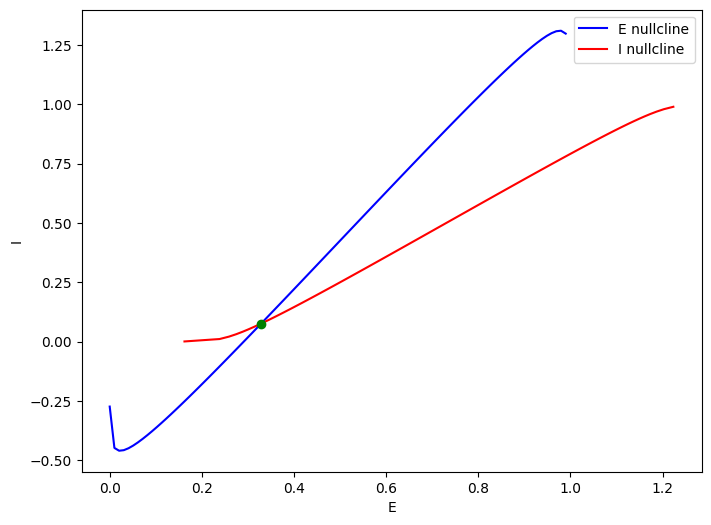

Intersection point (rE, rI): [0.32885525 0.07559249]


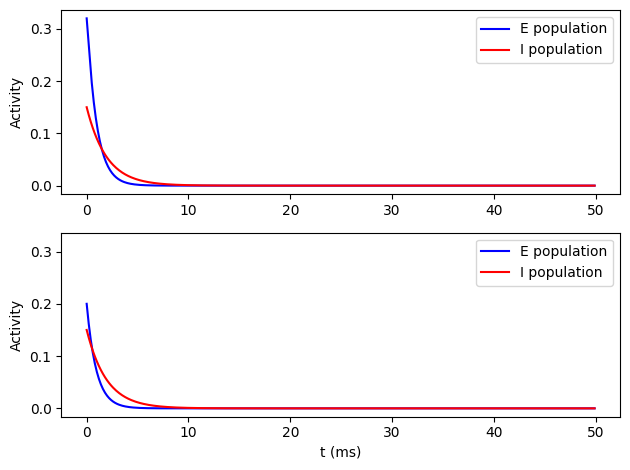

In [11]:
#parameters to change: a_E, a_I.

#baseline gain values:
#pars['a_E'] = 1.2
#pars['a_I'] = 1.0

higher_gain_test(5, 4.5, pars)

### Lower Gain: test 1

Critical Point [0. 0.] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)


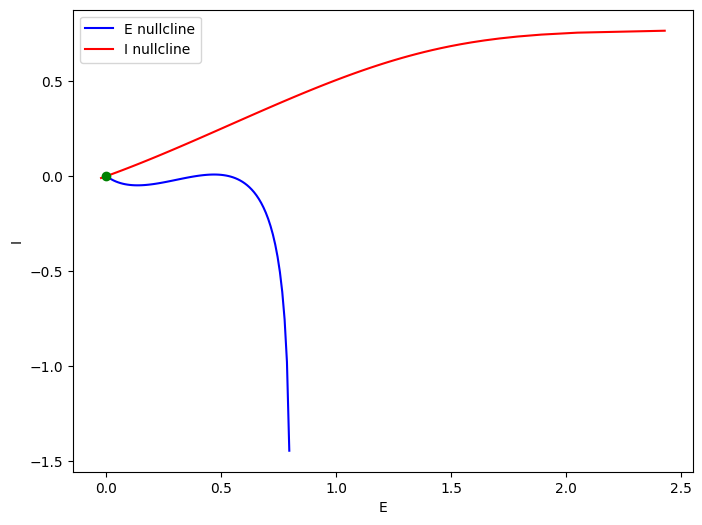

Intersection point (rE, rI): [0. 0.]


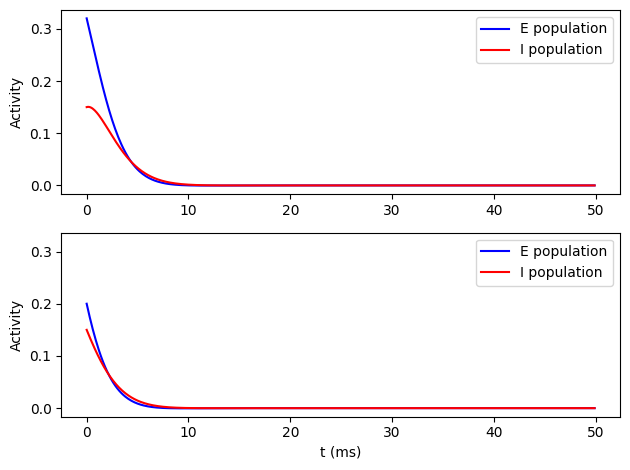

In [12]:
#parameters to change: a_E, a_I.

#baseline gain values:
#pars['a_E'] = 1.2
#pars['a_I'] = 1.0

def lower_gain_test(a, b, pars):
    # Copy of the pars dictionary to avoid modifying the original
    local_pars = pars.copy()
    
    # Update the copy with the new gain values
    local_pars['a_E'] = a
    local_pars['a_I'] = b

    # Generate nullclines using the updated local parameters
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])
    
    # Adjust the initial_guess and args as needed
    initial_guess = [0, 0]
    args = (local_pars['a_E'], local_pars['theta_E'], local_pars['wEE'], local_pars['wEI'], local_pars['I_ext_E'],
            local_pars['a_I'], local_pars['theta_I'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_I'])

    # Find the intersection point using fsolve
    intersection_point = fsolve(nullcline_difference, initial_guess, args=args)

    def get_eig_Jacobian(fp,tau_E, a_E, theta_E, wEE, wEI, I_ext_E, tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
        """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
        # Initialization
        rE, rI = fp
        J = np.zeros((2, 2))
        # Compute the four elements of the Jacobian matrix
        J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        # Compute and return the eigenvalues
        evals = np.linalg.eig(J)[0]
        return evals

    eig_1 = get_eig_Jacobian(intersection_point, **pars)

    aList = [intersection_point]
    aList2 = [eig_1]

    for inter, eig in zip(aList, aList2):
        if np.all(np.real(eig) < 0):
            print(f"Critical Point {inter} = {eig}: Stable (Attractive)")
        elif np.any(np.real(eig) > 0):
            print(f"Critical Point {inter} = {eig}: Unstable (Repulsive)")
        else:
            pass

    # Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    plt.scatter(intersection_point[0], intersection_point[1], color='green', zorder=5, label='Intersection point')
    plt.show()
    print(f"Intersection point (rE, rI): {intersection_point}")
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)

lower_gain_test(0.5, 0.3, pars)

### Lower Gain: test 2

Critical Point [-2.77547874e-17 -1.49605148e-18] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)


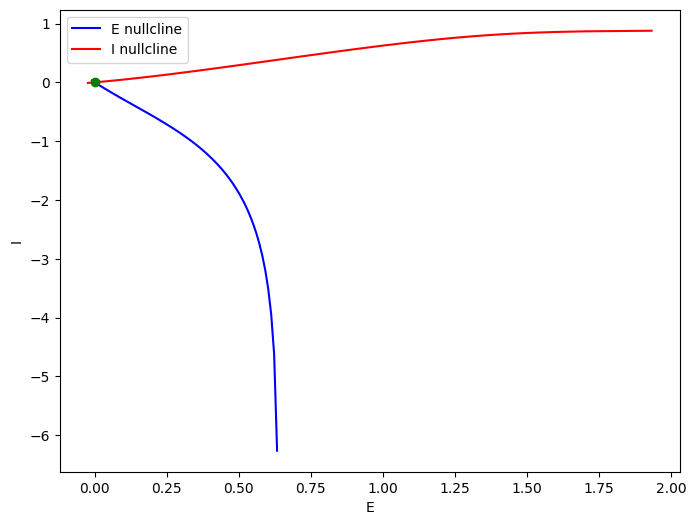

Intersection point (rE, rI): [-2.77547874e-17 -1.49605148e-18]


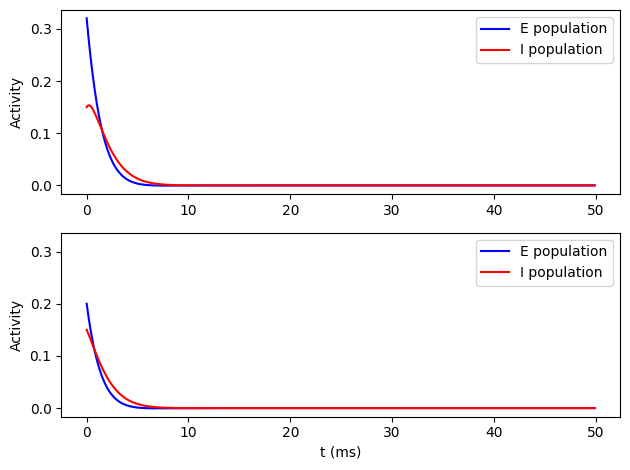

In [13]:
#parameters to change: a_E, a_I.

#baseline gain values:
#pars['a_E'] = 1.2
#pars['a_I'] = 1.0

lower_gain_test(0.2, 0.5, pars)

### Higher Threshold: test 1

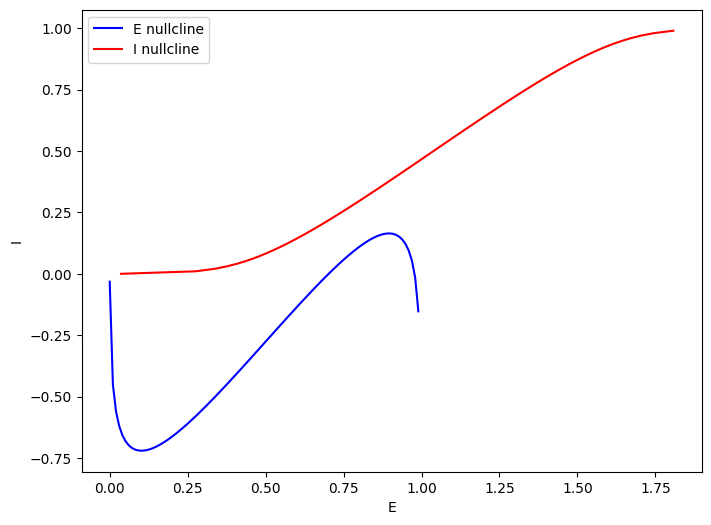

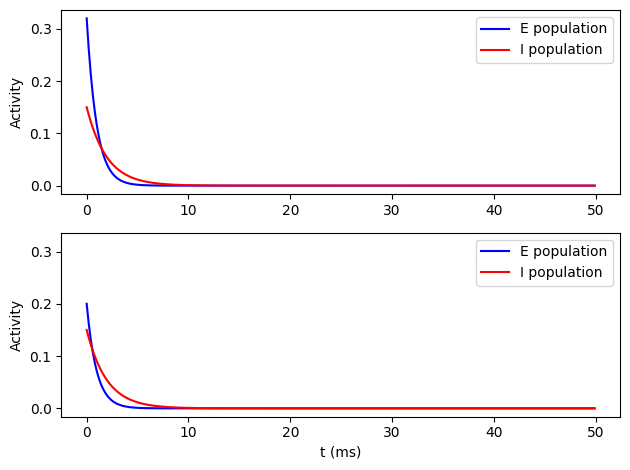

In [14]:
#parameters to change: theta_E, theta_I.

#baseline threshold values:
#pars['theta_E'] = 2.8
#pars['theta_I'] = 4.0
def higher_threshold_test(a, b, pars):
    # Copy of the pars dictionary to avoid modifying the original
    local_pars = pars.copy()
    
    # Update the copy with the new gain values
    local_pars['theta_E'] = a
    local_pars['theta_I'] = b

    # Generate nullclines using the updated local parameters
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])

    # Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    plt.show()
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)

higher_threshold_test(5.6, 8, pars)

### Higher Threshold: test 2

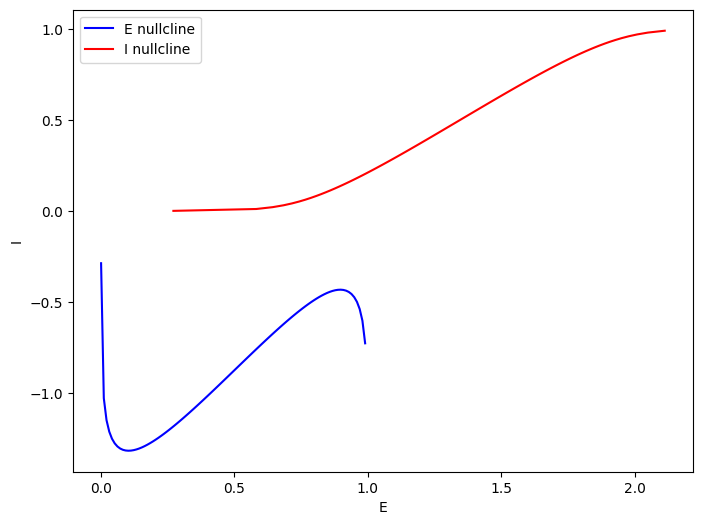

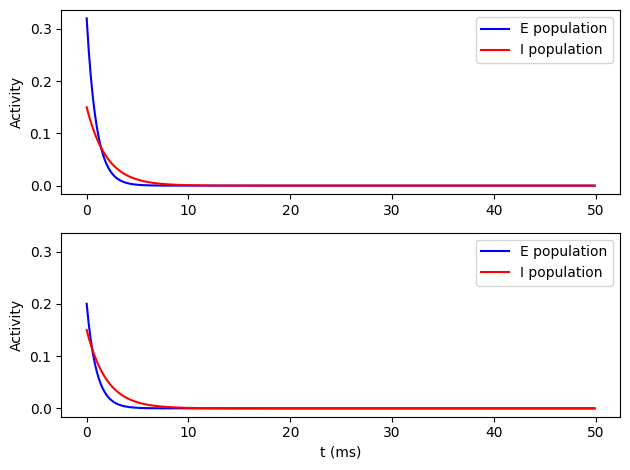

In [15]:
#parameters to change: theta_E, theta_I.

#baseline threshold values:
#pars['theta_E'] = 2.8
#pars['theta_I'] = 4.0

higher_threshold_test(8, 12, pars)

### Lower Threshold: test 1

Critical Point [0. 0.] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)
Critical Point [0.8249907  0.67204031] = [-0.64516491 -1.21039487]: Stable (Attractive)
Intersection point 1 (rE, rI): [0. 0.]
Intersection point 2 (rE, rI): [0.8249907  0.67204031]


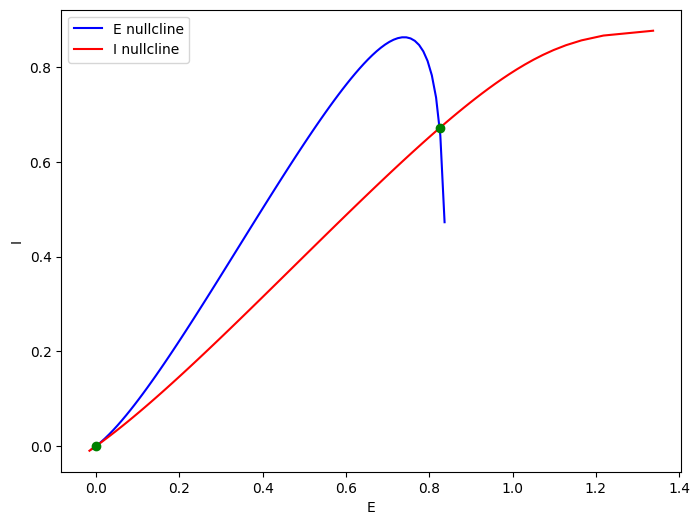

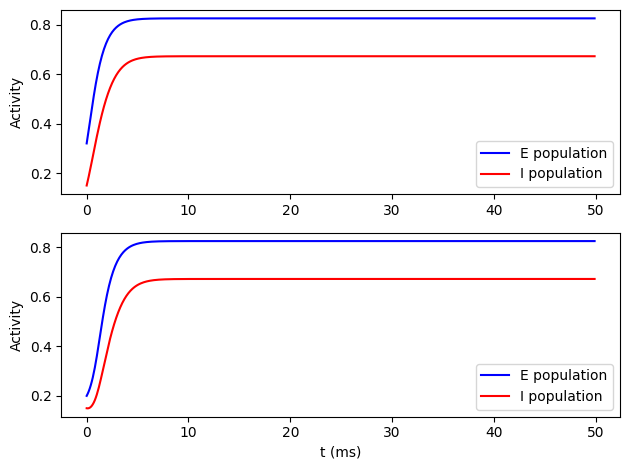

In [16]:
#parameters to change: theta_E, theta_I.

#baseline threshold values:
#pars['theta_E'] = 2.8
#pars['theta_I'] = 4.0

def lower_threshold_test(a, b, pars):
    # Copy of the pars dictionary to avoid modifying the original
    local_pars = pars.copy()
    
    # Update the copy with the new threshold values
    local_pars['theta_E'] = a
    local_pars['theta_I'] = b

    # Your existing code, but use local_pars instead of pars
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])
    
    # Adjust the initial_guess and args as needed
    initial_guess = [0, 0]
    initial_guess2 = [0.8,0.6]
    args = (local_pars['a_E'], local_pars['theta_E'], local_pars['wEE'], local_pars['wEI'], local_pars['I_ext_E'],
            local_pars['a_I'], local_pars['theta_I'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_I'])

    # Find the intersection point using fsolve
    intersection_point = fsolve(nullcline_difference, initial_guess, args=args)
    intersection_point2 = fsolve(nullcline_difference, initial_guess2, args=args)
    
    def get_eig_Jacobian(fp,tau_E, a_E, theta_E, wEE, wEI, I_ext_E, tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
        """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
        # Initialization
        rE, rI = fp
        J = np.zeros((2, 2))
        # Compute the four elements of the Jacobian matrix
        J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        # Compute and return the eigenvalues
        evals = np.linalg.eig(J)[0]
        return evals

    eig_1 = get_eig_Jacobian(intersection_point, **pars)
    eig_2 = get_eig_Jacobian(intersection_point2, **pars)

    aList = [intersection_point, intersection_point2]
    aList2 = [eig_1, eig_2]

    for inter, eig in zip(aList, aList2):
        if np.all(np.real(eig) < 0):
            print(f"Critical Point {inter} = {eig}: Stable (Attractive)")
        elif np.any(np.real(eig) > 0):
            print(f"Critical Point {inter} = {eig}: Unstable (Repulsive)")
        else:
            pass

    #Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])
    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    plt.scatter(intersection_point[0], intersection_point[1], color='green', zorder=5, label='Intersection point')
    plt.scatter(intersection_point2[0], intersection_point2[1], color='green', zorder=5, label='Intersection point')
    print(f"Intersection point 1 (rE, rI): {intersection_point}")
    print(f"Intersection point 2 (rE, rI): {intersection_point2}")
    plt.show()
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)


lower_threshold_test(1.4, 2, pars)

### Lower Threshold: test 2

Critical Point [0. 0.] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)
Critical Point [0.6756434  0.56249927] = [ 0.39548551 -0.883022  ]: Unstable (Repulsive)
Intersection point 1 (rE, rI): [0. 0.]
Intersection point 2 (rE, rI): [0.6756434  0.56249927]


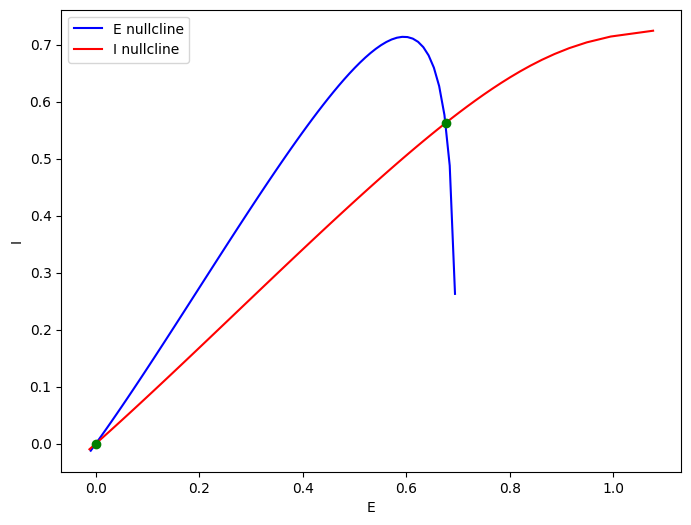

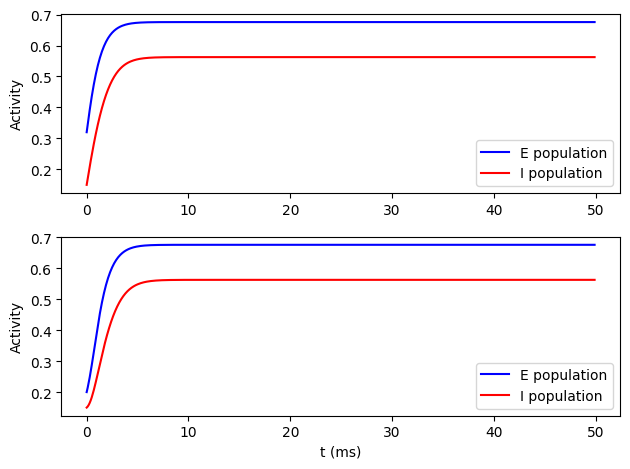

In [17]:
#baseline threshold values:
#pars['theta_E'] = 2.8
#pars['theta_I'] = 4.0

def lower_threshold_test(a, b, pars):
    # Copy of the pars dictionary to avoid modifying the original
    local_pars = pars.copy()
    
    # Update the copy with the new threshold values
    local_pars['theta_E'] = a
    local_pars['theta_I'] = b

    # Your existing code, but use local_pars instead of pars
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])
    
    # Adjust the initial_guess and args as needed
    initial_guess = [0, 0]
    initial_guess2 = [0.65,0.55]
    args = (local_pars['a_E'], local_pars['theta_E'], local_pars['wEE'], local_pars['wEI'], local_pars['I_ext_E'],
            local_pars['a_I'], local_pars['theta_I'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_I'])

    # Find the intersection point using fsolve
    intersection_point = fsolve(nullcline_difference, initial_guess, args=args)
    intersection_point2 = fsolve(nullcline_difference, initial_guess2, args=args)

    def get_eig_Jacobian(fp,tau_E, a_E, theta_E, wEE, wEI, I_ext_E, tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
        """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
        # Initialization
        rE, rI = fp
        J = np.zeros((2, 2))
        # Compute the four elements of the Jacobian matrix
        J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        # Compute and return the eigenvalues
        evals = np.linalg.eig(J)[0]
        return evals

    eig_1 = get_eig_Jacobian(intersection_point, **pars)
    eig_2 = get_eig_Jacobian(intersection_point2, **pars)

    aList = [intersection_point, intersection_point2]
    aList2 = [eig_1, eig_2]

    for inter, eig in zip(aList, aList2):
        if np.all(np.real(eig) < 0):
            print(f"Critical Point {inter} = {eig}: Stable (Attractive)")
        elif np.any(np.real(eig) > 0):
            print(f"Critical Point {inter} = {eig}: Unstable (Repulsive)")
        else:
            pass
    

    #Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])
    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    plt.scatter(intersection_point[0], intersection_point[1], color='green', zorder=5, label='Intersection point')
    plt.scatter(intersection_point2[0], intersection_point2[1], color='green', zorder=5, label='Intersection point')
    print(f"Intersection point 1 (rE, rI): {intersection_point}")
    print(f"Intersection point 2 (rE, rI): {intersection_point2}")
    plt.show()
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)

lower_threshold_test(0.7, 1, pars)

## Task 4: Change the connection strengths parameters

### Test 1: Enhanced Inhibitory to Excitatory Influence


Increasing the inhibitory effect on the excitatory population can demonstrate the impact of strong inhibition on network dynamics.

Critical Point [0. 0.] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)


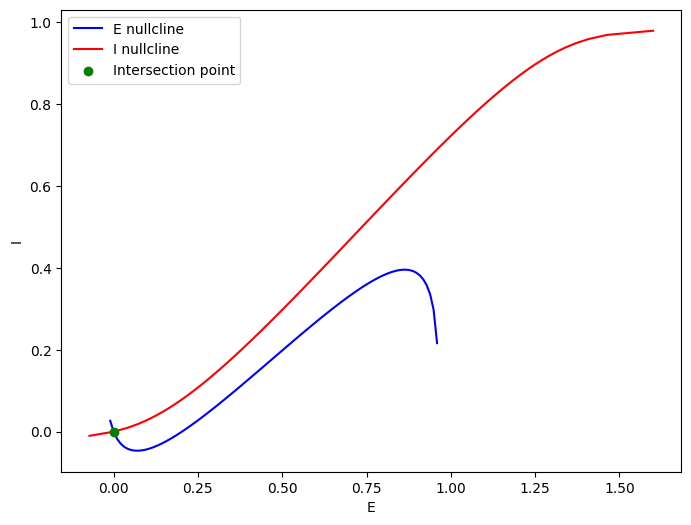

Intersection point 1 (rE, rI): [0. 0.]


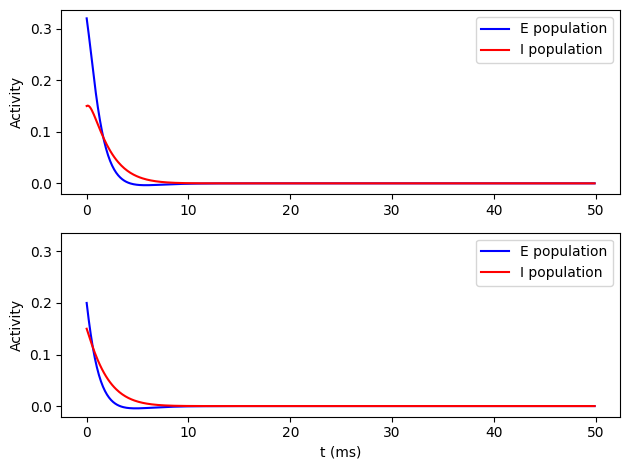

In [39]:
#parameters to change: wEE, wEI, wIE, wII.

#baseline connections values:
# pars['wEE'] = 9.   # E to E
# pars['wEI'] = 4.   # I to E
# pars['wIE'] = 13.  # E to I
# pars['wII'] = 11.  # I to I

def change_connection_strengths(a, b, c, d, pars):
    # Create a local copy of the pars dictionary to modify
    local_pars = pars.copy()

    # Update connection strengths in the local copy
    local_pars['wEE'] = a   
    local_pars['wEI'] = b   
    local_pars['wIE'] = c   
    local_pars['wII'] = d

    # Generate nullclines using the updated local parameters
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])
    
    initial_guess = [0, 0]
    args = (local_pars['a_E'], local_pars['theta_E'], local_pars['wEE'], local_pars['wEI'], local_pars['I_ext_E'],
            local_pars['a_I'], local_pars['theta_I'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_I'])
    # Find the intersection point using fsolve
    intersection_point = fsolve(nullcline_difference, initial_guess, args=args)

    def get_eig_Jacobian(fp,tau_E, a_E, theta_E, wEE, wEI, I_ext_E, tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
        """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
        # Initialization
        rE, rI = fp
        J = np.zeros((2, 2))
        # Compute the four elements of the Jacobian matrix
        J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        # Compute and return the eigenvalues
        evals = np.linalg.eig(J)[0]
        return evals

    eig_1 = get_eig_Jacobian(intersection_point, **pars)

    aList = [intersection_point]
    aList2 = [eig_1]

    for inter, eig in zip(aList, aList2):
        if np.all(np.real(eig) < 0):
            print(f"Critical Point {inter} = {eig}: Stable (Attractive)")
        elif np.any(np.real(eig) > 0):
            print(f"Critical Point {inter} = {eig}: Unstable (Repulsive)")
        else:
            pass

    #Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])
    
    # Plot the nullclines
    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.scatter(intersection_point[0], intersection_point[1], color='green', zorder=5, label='Intersection point')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    plt.show()
    print(f"Intersection point 1 (rE, rI): {intersection_point}")
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)


# new connection strengths:
# wEE = 9.0 (Kept the same for direct comparison)
# wEI = 8.0 (Increased from 4.0 to enhance the inhibitory effect on E)
# wIE = 13.0 (kept the same)
# wII = 11.0 (Kept the same)

change_connection_strengths(9.0, 8.0, 13.0, 11.0, pars)

### Test 2: Balanced Mutual Inhibition

Critical Point [0. 0.] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)


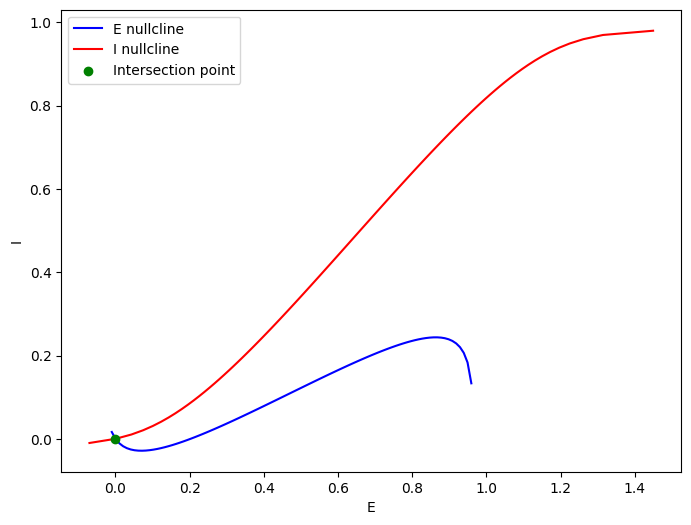

Intersection point 1 (rE, rI): [0. 0.]


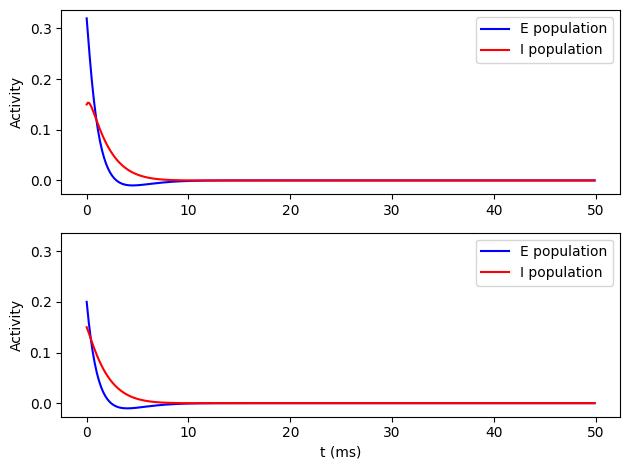

In [41]:
#parameters to change: wEE, wEI, wIE, wII.

#baseline connections values:
# pars['wEE'] = 9.   # E to E
# pars['wEI'] = 4.   # I to E
# pars['wIE'] = 13.  # E to I
# pars['wII'] = 11.  # I to I

# new connection strengths:
# wEE = 9.0 (Kept the same)
# wEI = 13.0 (Increased to match the strength of E to I)
# wIE = 13.0 (kept the same)
# wII = 9.0 (Decreased to match the strength of E to E)

change_connection_strengths(9.0, 13.0, 13.0, 9.0, pars)


### Test 3

Critical Point [0. 0.] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)


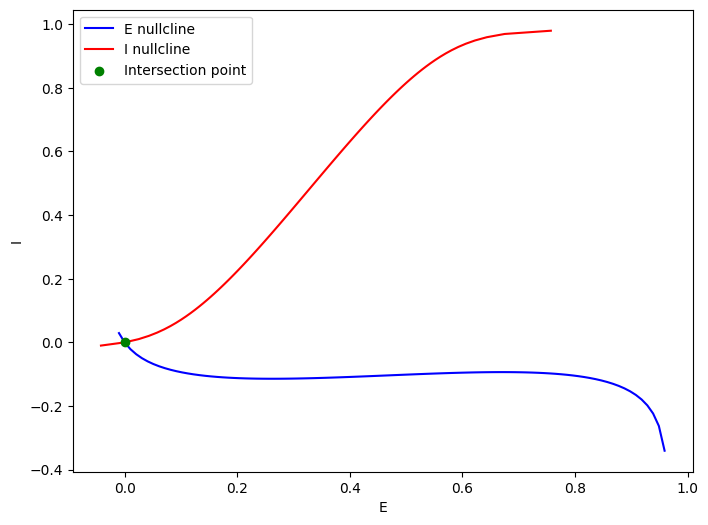

Intersection point 1 (rE, rI): [0. 0.]


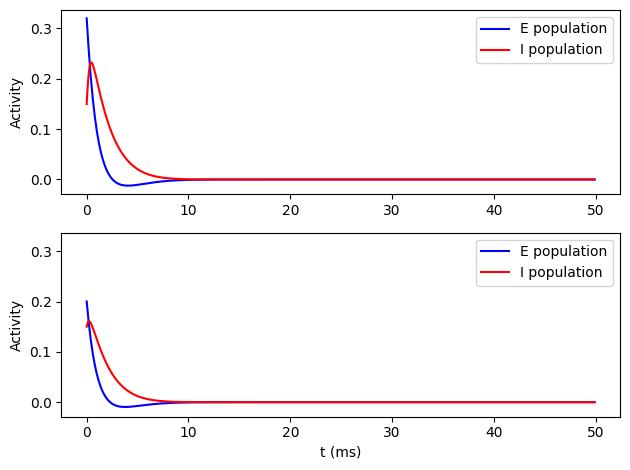

In [28]:
change_connection_strengths(4.0, 9.0, 21.0, 6.0, pars)

### Test 4

New parameter values:
- wEE = 16.0
- wEI = 3.0
- wIE = 7.0
- wII = 6.0

Critical Point [0. 0.] = [-0.62338386+0.13110957j -0.62338386-0.13110957j]: Stable (Attractive)
Critical Point [0.05476284 0.00711644] = [-0.54758444+0.19338256j -0.54758444-0.19338256j]: Stable (Attractive)


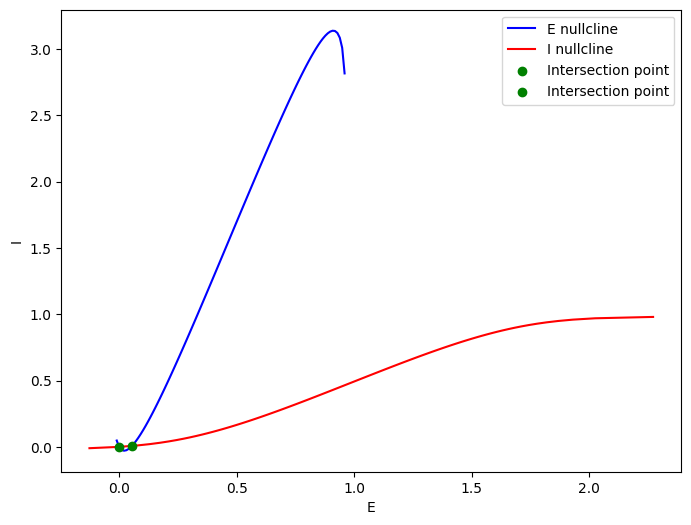

Intersection point 1 (rE, rI): [0. 0.]
Intersection point 2 (rE, rI): [0.05476284 0.00711644]


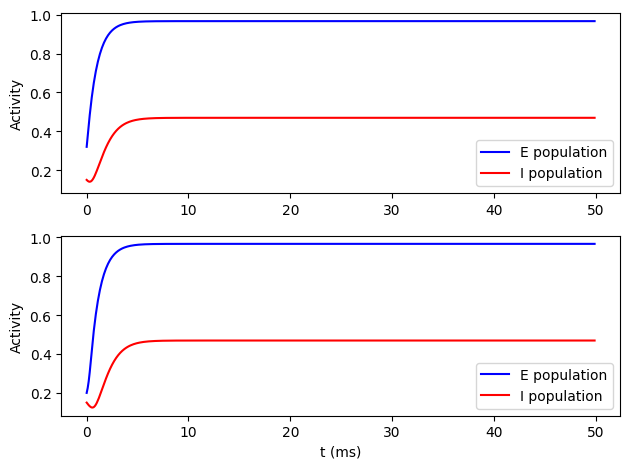

In [42]:
def change_connection_strengths(a, b, c, d, pars):
    # Create a local copy of the pars dictionary to modify
    local_pars = pars.copy()

    # Update connection strengths in the local copy
    local_pars['wEE'] = a   
    local_pars['wEI'] = b   
    local_pars['wIE'] = c   
    local_pars['wII'] = d

    # Generate nullclines using the updated local parameters
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])
    
    initial_guess = [0, 0]
    initial_guess2 = [0.1,0]
    args = (local_pars['a_E'], local_pars['theta_E'], local_pars['wEE'], local_pars['wEI'], local_pars['I_ext_E'],
            local_pars['a_I'], local_pars['theta_I'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_I'])
    # Find the intersection point using fsolve
    intersection_point = fsolve(nullcline_difference, initial_guess, args=args)
    intersection_point2 = fsolve(nullcline_difference, initial_guess2, args=args)
    
    def get_eig_Jacobian(fp,tau_E, a_E, theta_E, wEE, wEI, I_ext_E, tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
        """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
        # Initialization
        rE, rI = fp
        J = np.zeros((2, 2))
        # Compute the four elements of the Jacobian matrix
        J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        # Compute and return the eigenvalues
        evals = np.linalg.eig(J)[0]
        return evals

    eig_1 = get_eig_Jacobian(intersection_point, **pars)
    eig_2 = get_eig_Jacobian(intersection_point2, **pars)

    aList = [intersection_point, intersection_point2]
    aList2 = [eig_1, eig_2]

    for inter, eig in zip(aList, aList2):
        if np.all(np.real(eig) < 0):
            print(f"Critical Point {inter} = {eig}: Stable (Attractive)")
        elif np.any(np.real(eig) > 0):
            print(f"Critical Point {inter} = {eig}: Unstable (Repulsive)")
        else:
            pass



    #Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])
    
    # Plot the nullclines
    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.scatter(intersection_point[0], intersection_point[1], color='green', zorder=5, label='Intersection point')
    plt.scatter(intersection_point2[0], intersection_point2[1], color='green', zorder=5, label='Intersection point')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    plt.show()
    print(f"Intersection point 1 (rE, rI): {intersection_point}")
    print(f"Intersection point 2 (rE, rI): {intersection_point2}")
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)

change_connection_strengths(16.0, 3.0, 7.0, 6.0, pars)

## Task 5: Add an external stimulus

### Test 1: Mild External Drive

Mild external stimuli can be used to simulate a low level of background activity that might be present in a neural environment, such as spontaneous neural firing or a weak sensory stimulus.

Critical Point [0.95179943 0.73949671] = [-0.91588841 -1.59250172]: Stable (Attractive)
Intersection point (rE, rI): [0.95179943 0.73949671]


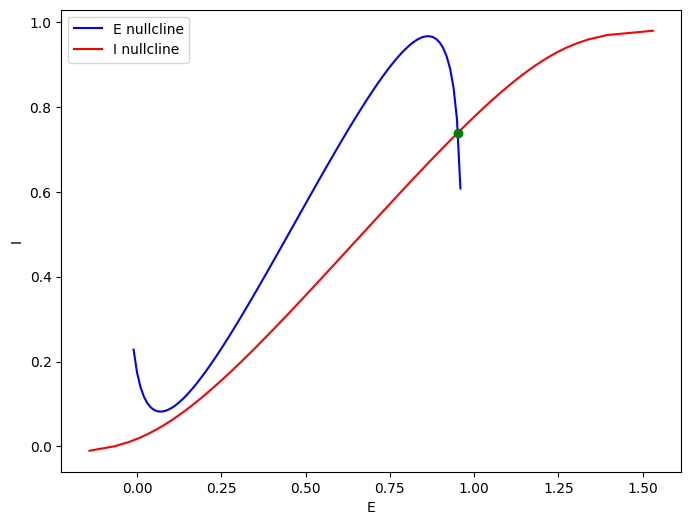

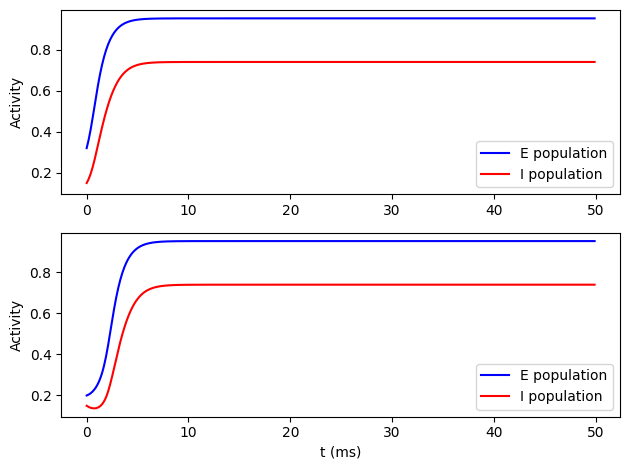

In [43]:
def added_external_stimulus(a, b, pars):
    # Make a copy of the pars dictionary to avoid modifying the original
    local_pars = pars.copy()
    
    # Update the copy with the new gain values
    
    local_pars['I_ext_E'] = a
    local_pars['I_ext_I'] = b

    # Generate nullclines using the updated local parameters
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])
        
    initial_guess = [0.957, 0.65]
    args = (local_pars['a_E'], local_pars['theta_E'], local_pars['wEE'], local_pars['wEI'], local_pars['I_ext_E'],
            local_pars['a_I'], local_pars['theta_I'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_I'])

    # Find the intersection point using fsolve
    intersection_point = fsolve(nullcline_difference, initial_guess, args=args)
    def get_eig_Jacobian(fp,tau_E, a_E, theta_E, wEE, wEI, I_ext_E, tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
        """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
        # Initialization
        rE, rI = fp
        J = np.zeros((2, 2))
        # Compute the four elements of the Jacobian matrix
        J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

        J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

        # Compute and return the eigenvalues
        evals = np.linalg.eig(J)[0]
        return evals

    eig_1 = get_eig_Jacobian(intersection_point, **pars)
    aList = [intersection_point]
    aList2 = [eig_1]

    for inter, eig in zip(aList, aList2):
        if np.all(np.real(eig) < 0):
            print(f"Critical Point {inter} = {eig}: Stable (Attractive)")
        elif np.any(np.real(eig) > 0):
            print(f"Critical Point {inter} = {eig}: Unstable (Repulsive)")
        else:
            pass

    

    # Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    plt.scatter(intersection_point[0], intersection_point[1], color='green', zorder=5, label='Intersection point')
    print(f"Intersection point (rE, rI): {intersection_point}")
    plt.show()
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)


added_external_stimulus(0.7, 0.9, pars)

### Test 2: Strong External Drive

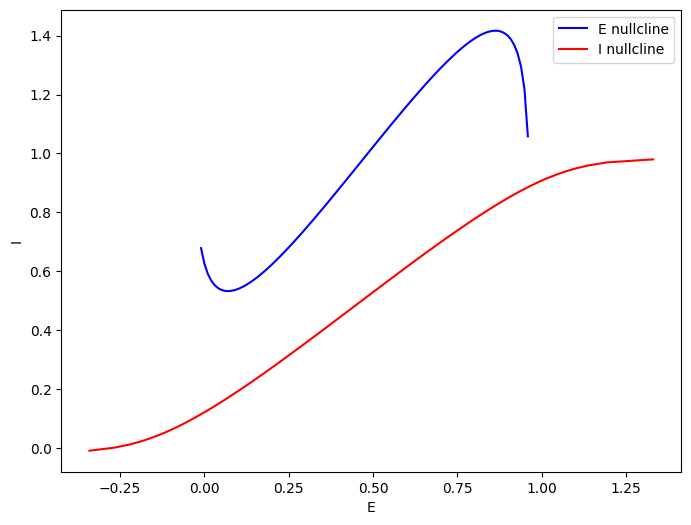

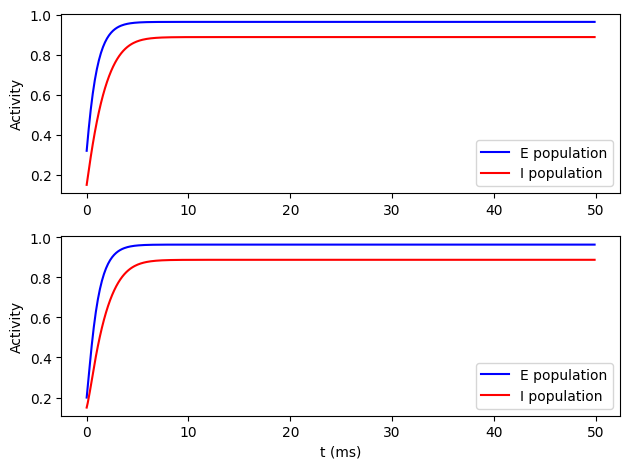

In [31]:
def added_external_stimulus(a, b, pars):
    # Make a copy of the pars dictionary to avoid modifying the original
    local_pars = pars.copy()
    
    # Update the copy with the new gain values
    
    local_pars['I_ext_E'] = a
    local_pars['I_ext_I'] = b

    # Generate nullclines using the updated local parameters
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])
    
    # Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    plt.show()
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)

added_external_stimulus(2.5, 3.5, pars)

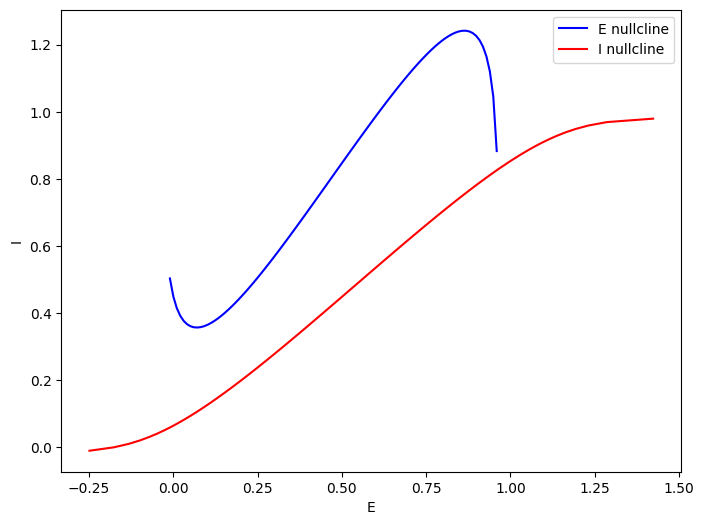

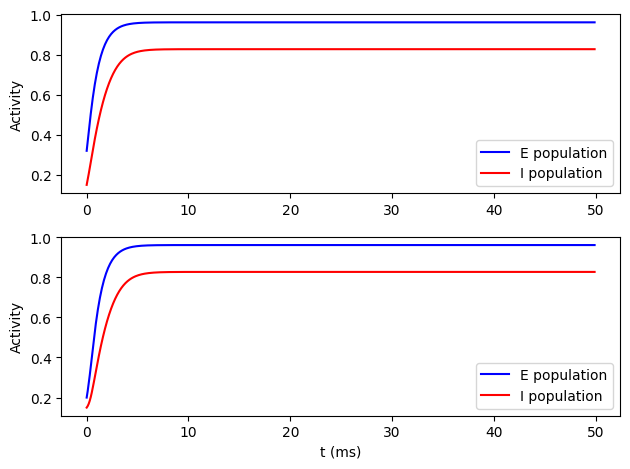

In [32]:
def added_external_stimulus(a, b, pars,c):
    # Make a copy of the pars dictionary to avoid modifying the original
    local_pars = pars.copy()
    
    
    # Update the copy with the new gain values
    
    local_pars['I_ext_E'] = a
    local_pars['I_ext_I'] = b

    # Generate nullclines using the updated local parameters
    Exc_null_rE = np.linspace(-0.01, 1, 100)
    Exc_null_rI = nullcline_E(Exc_null_rE, a_E=local_pars['a_E'], theta_E=local_pars['theta_E'], wEE=local_pars['wEE'], wEI=local_pars['wEI'], I_ext_E=local_pars['I_ext_E'])
    Inh_null_rI = np.linspace(-0.01, 1, 100)
    Inh_null_rE = nullcline_I(Inh_null_rI, a_I=local_pars['a_I'], theta_I=local_pars['theta_I'], wIE=local_pars['wIE'], wII=local_pars['wII'], I_ext_I=local_pars['I_ext_I'])
        
    initial_guess = [0.957, 0.65]
    args = (local_pars['a_E'], local_pars['theta_E'], local_pars['wEE'], local_pars['wEI'], local_pars['I_ext_E'],
            local_pars['a_I'], local_pars['theta_I'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_I'])

    # Find the intersection point using fsolve
    intersection_point = fsolve(nullcline_difference, initial_guess, args=args)

    # Simulate trajectories using parameters from local_pars
    rE1, rI1 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.32, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    rE2, rI2 = simulate_wc(local_pars['tau_E'], local_pars['a_E'], local_pars['theta_E'], local_pars['tau_I'], local_pars['a_I'], local_pars['theta_I'],
                           local_pars['wEE'], local_pars['wEI'], local_pars['wIE'], local_pars['wII'], local_pars['I_ext_E'], local_pars['I_ext_I'],
                           rE_init=0.2, rI_init=0.15, dt=local_pars['dt'], range_t=local_pars['range_t'])

    plt.figure(figsize=(8, 6))
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')
    if c == 1:
      plt.scatter(intersection_point[0], intersection_point[1], color='green', zorder=5, label='Intersection point')
      print(f"Intersection point (rE, rI): {intersection_point}")
    else:
      pass
    plt.show()
    my_test_plot(local_pars['range_t'], rE1, rI1, rE2, rI2)

added_external_stimulus(1.8, 2.3, pars, 0)

### Test 3: Unbalanced External Drive

An unbalanced stimulus might represent situations where one population is more strongly driven than the other, such as during certain cognitive tasks or due to pathological conditions.

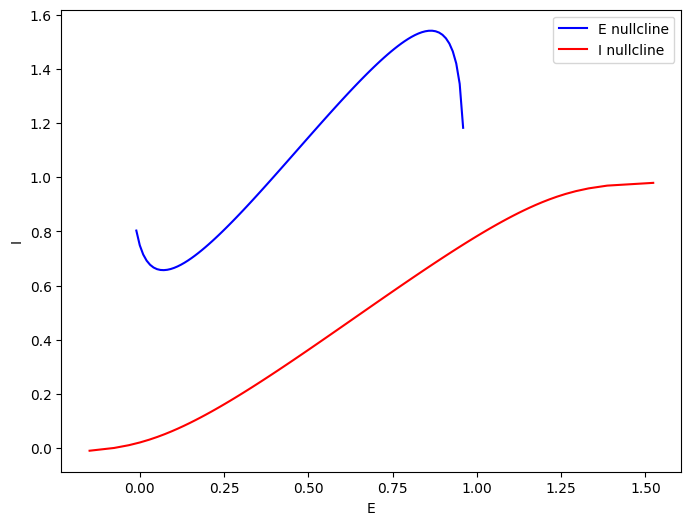

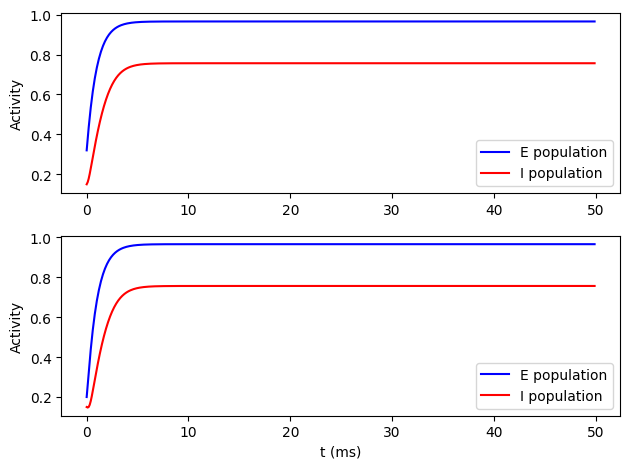

In [33]:
added_external_stimulus(3, 1, pars, 0)

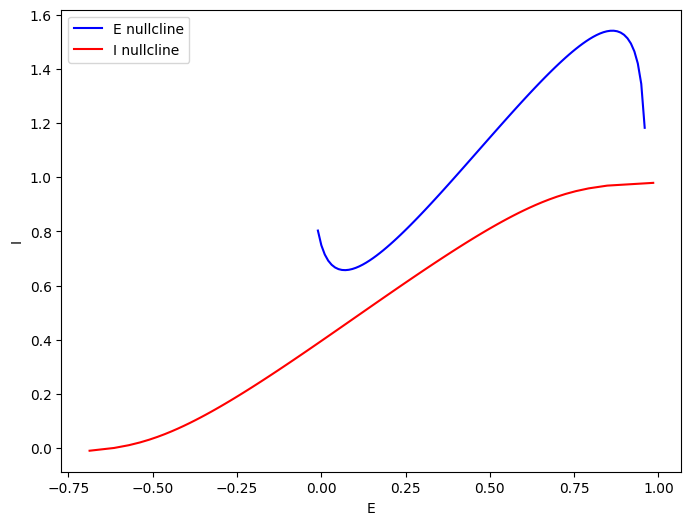

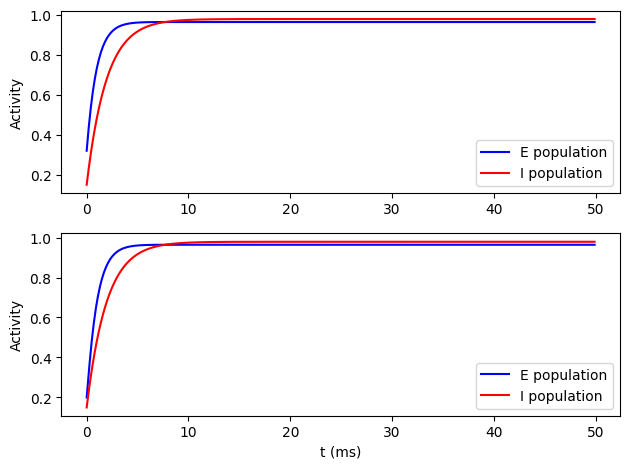

In [34]:
added_external_stimulus(3, 8, pars, 0)